In [1]:
# Check if GPU is mounted

import torch
x = torch.cuda.is_available()
print(x)

True


In [2]:
# To make sure the dataset is accessable from my server

import sys,os,os.path
os.environ['HTTP_PROXY']="192.168.0.200:7890"
os.environ['HTTPS_PROXY']="192.168.0.200:7890"

import requests

In [3]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional, Callable, Union
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader, Subset, random_split

from collections import OrderedDict

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents, ClientManager
from flwr.server.strategy import Strategy, FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr.common import FitRes, Parameters, parameters_to_ndarrays
from flwr.server.client_proxy import ClientProxy

device = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device(device)  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.14.0 / PyTorch 2.5.1+cu121


In [4]:
# Some network, for MNIST dataset
skip_layer = False
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        if(skip_layer):
            self.skip_layer = nn.Linear(16 * 4 * 4, 120)
            self.fc1 = nn.Linear(120, 120)
        else:
            self.fc1 = nn.Linear(16 * 4 * 4, 120)
            
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        if(skip_layer):
            x = torch.relu(self.skip_layer(x))
            
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
from collections import defaultdict


transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


# Split into 8 datasets
NUM_CLIENTS = 5
total_size = len(mnist_dataset)
indices = list(range(total_size))
np.random.shuffle(indices)
split_size = total_size // NUM_CLIENTS

subsets = [Subset(mnist_dataset, indices[i * split_size:(i + 1) * split_size]) for i in range(NUM_CLIENTS)]

# 1. Vanilla dataset
transform_1 = transforms.ToTensor()

# 2. remove all digit '7'
class RemoveLabel7:
    def __call__(self, dataset):
        indices = [i for i, (_, label) in enumerate(dataset) if label != 7]
        return Subset(dataset, indices)

# 3. Apply Gaussian Blur
class ApplyGaussianBlur:
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        img = transforms.ToPILImage()(img)
        img = img.filter(ImageFilter.GaussianBlur(self.radius))
        img = transforms.ToTensor()(img)
        return img

transform_3 = ApplyGaussianBlur(radius=1)

class LerpToWhiteNoise:
    def __init__(self, alpha=0.5):
        self.alpha = alpha

    def __call__(self, img):
        noise = torch.randn_like(img)
        return (1 - self.alpha) * img + self.alpha * noise

noiseImg = LerpToWhiteNoise(alpha=1)

# 4. Rotate 45 degree
transform_4 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: img.rotate(45, fillcolor=(0,))),
    transforms.ToTensor()
])

# 5. Random mean shift

random_direction = np.random.rand(2) * 10
class RandomMeanShift:
    def __init__(self, shift_vector):
        self.shift_vector = shift_vector

    def __call__(self, img):
        shift_x, shift_y = self.shift_vector
        img = np.array(img)
        img = np.roll(img, int(shift_y), axis=2)  # Shift along height
        img = np.roll(img, int(shift_x), axis=1)  # Shift along width
        return torch.tensor(img)
    

In [6]:
# Build the corresponding loaders

def create_loader(subset, transType):
    train_size = int(0.7 * len(subset))
    val_size = int(0.1 * len(subset))
    test_size = len(subset) - train_size - val_size
    train_subset, val_subset, test_subset = random_split(subset, [train_size, val_size, test_size])


    if transType == "Gaussian Blur":
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_3(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    elif transType == "Rotate 45":
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([transform_4(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    elif transType == "White noise":
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([noiseImg(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([noiseImg(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([noiseImg(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    elif transType == "Random mean shift":
        rand_trans = RandomMeanShift(random_direction)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=lambda batch: (torch.stack([rand_trans(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([rand_trans(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=lambda batch: (torch.stack([rand_trans(x) for x, y in batch]), torch.tensor([y for x, y in batch])))
    elif transType == "Local number":
        test_subset = subsets[0]
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    
    else:
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    return (train_loader, val_loader, test_loader)

loaders = []
fallbackType = "Default"
subsetTypes = []
for i, subset in enumerate(subsets):
    random_direction = np.random.rand(2) * 20 - 10
    if i < len(subsetTypes):
        trans_type = subsetTypes[i] 
    else:
        trans_type = fallbackType
    loaders.append(create_loader(subset, trans_type))

c:\Users\andri\OneDrive\Desktop\_EthBoyyyyyyy\DL\DLProject\eth-dl-project\.venv\Lib\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


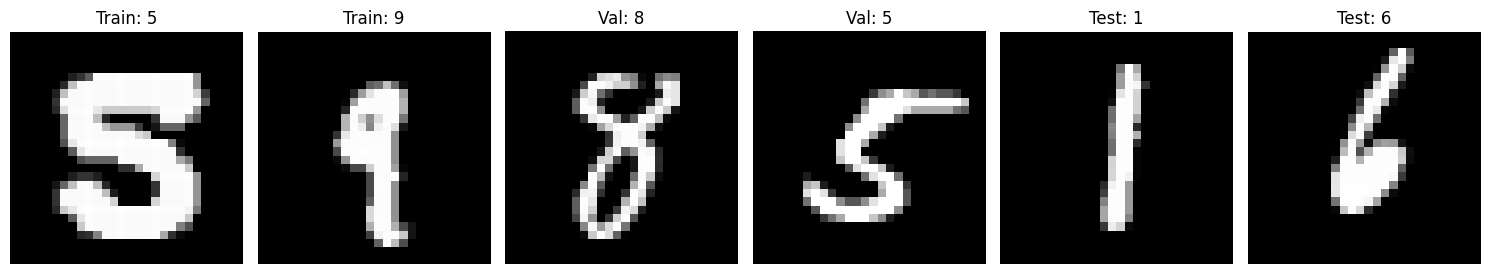

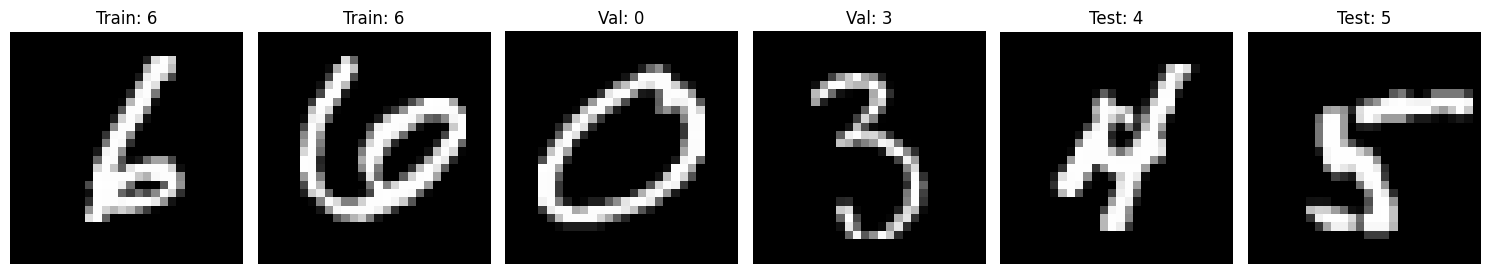

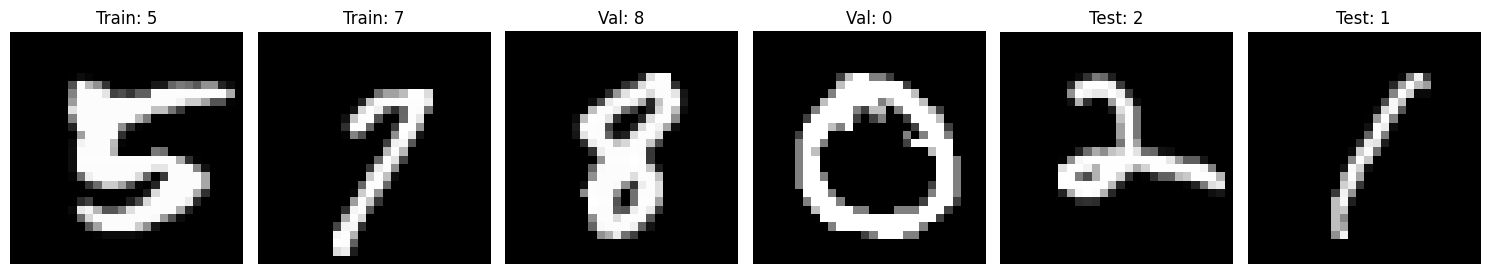

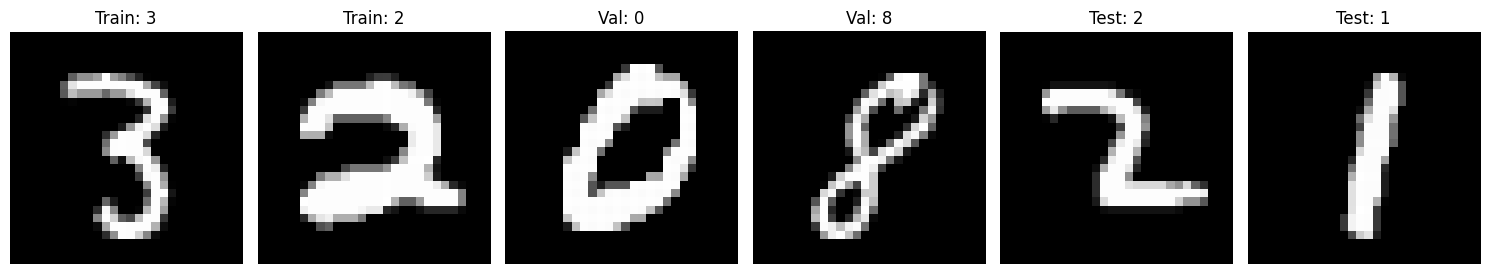

In [7]:
for client_idx, (train_loader, val_loader, test_loader) in enumerate(loaders):
    if(client_idx >= 4):
        break
    fig, axes = plt.subplots(1, 6, figsize=(15, 6))
    
    # Train
    for j, (x, y) in enumerate(train_loader):
        if j >= 2:
            break
        axes[j].imshow(x[0].squeeze(), cmap='gray')
        axes[j].axis('off')
        axes[j].set_title(f"Train: {y[0].item()}")
    
    # Validation
    for j, (x, y) in enumerate(val_loader):
        if j >= 2:
            break
        axes[j+2].imshow(x[0].squeeze(), cmap='gray')
        axes[j+2].axis('off')
        axes[j+2].set_title(f"Val: {y[0].item()}")
    
    # Test
    for j, (x, y) in enumerate(test_loader):
        if j >= 2:
            break
        axes[j+4].imshow(x[0].squeeze(), cmap='gray')
        axes[j+4].axis('off')
        axes[j+4].set_title(f"Test: {y[0].item()}")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [8]:
# Wrap the above ugly code of flower client into a class

# Helper Functions

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def train(net, trainloader, epochs: int, verbose=False, device = "cuda"):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    net.to(device)
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader, device):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    net.to(device)
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Custom Client Class
class FLClient(NumPyClient):
    """A Flower client that holds its own model and training data."""

    def __init__(
        self,
        net: nn.Module,
        trainloader: DataLoader,
        valloader: DataLoader,
        device: torch.device,
        client_id: int,
        epochs: int = 1,
    ):
        super().__init__()
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.device = device
        self.client_id = client_id
        self.epochs = epochs

    def get_parameters(self, config: Dict[str, Scalar]) -> List[np.ndarray]:
        """Return the current local model parameters."""
        return get_parameters(self.net)

    def fit(
        self, parameters: List[np.ndarray], config: Dict[str, Scalar]
    ) -> Tuple[List[np.ndarray], int, Dict[str, Scalar]]:
        # Set parameters except for the fourth layer
        current_params = get_parameters(self.net)
        
        for i, param in enumerate(parameters):
            if not skip_layer or i != 4:  # Skip the fourth layer
                current_params[i] = param
        set_parameters(self.net, current_params)
        
        train(self.net, self.trainloader, device=self.device, epochs=self.epochs, verbose=False)
        new_params = get_parameters(self.net)
        # Return partition-id in the metrics
        # The simplest way to store the model
        return new_params, len(self.trainloader.dataset), {"partition-id": self.client_id}

    def evaluate(
        self, parameters: List[np.ndarray], config: Dict[str, Scalar]
    ) -> Tuple[float, int, Dict[str, Scalar]]:
        # Set parameters except for the fourth layer
        current_params = get_parameters(self.net)
        
        for i, param in enumerate(parameters):
            if not skip_layer or i != 4:  # Skip the fourth layer
                current_params[i] = param
                    
        set_parameters(self.net, current_params)
        
        loss, accuracy = test(self.net, self.valloader, self.device)
        print(f"[Client {self.client_id}] Evaluate -> Loss: {loss:.4f}, Accuracy: {accuracy:.4f} :::::: {current_params[3]}")
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

class DefaultStrategy(FedAvg):

    # A custom strategy to store all the parameters.
    # https://github.com/adap/flower/issues/487
    # https://flower.ai/docs/framework/how-to-save-and-load-model-checkpoints.html

    def __init__(self, model: type, total_round: int, only_last: bool = True, save_dir: str = "models", *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.model = model
        self.total_round = total_round
        self.only_last = only_last

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[Union[tuple[ClientProxy, FitRes], BaseException]],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:
        """
        Aggregate model weights using weighted average.
        Also save each client's model and the global server model.
        """

        if self.only_last and server_round < self.total_round:
            return super().aggregate_fit(server_round, results, failures)

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )

        # For each client which returned FitRes, save the client model
        for (_, fit_res) in results:
            id_ = fit_res.metrics["partition-id"]

            client_parameters: Optional[Parameters] = fit_res.parameters
            if client_parameters is not None:
                net = self.model()
                print(f"[Round {server_round}] Saving model for client {id_}...")

                # Convert `Parameters` to `list[np.ndarray]`
                client_ndarrays : list[np.ndarray] = parameters_to_ndarrays(
                    client_parameters
                )

                # Convert `list[np.ndarray]` to PyTorch `state_dict`
                params_dict = zip(net.state_dict().keys(), client_ndarrays)
                state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
                net.load_state_dict(state_dict, strict=True)

                # Save the model to disk
                torch.save(net.state_dict(), f"{self.save_dir}/client-{server_round}-{id_}.pth")

        # If `aggregated_parameters` is not None, update the global net and save it
        if aggregated_parameters is not None:
            net = self.model()
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `list[np.ndarray]`
            aggregated_ndarrays: list[np.ndarray] = parameters_to_ndarrays(
                aggregated_parameters
            )

            # Convert `list[np.ndarray]` to PyTorch `state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            net.load_state_dict(state_dict, strict=True)

            # Save the model to disk
            torch.save(net.state_dict(), f"{self.save_dir}/server-{server_round}.pth")

        return aggregated_parameters, aggregated_metrics


In [9]:
# Use the following class to run the experiment

# You need to provide the following information:
# 1. The Network class (dont instantiate it)
#       (assume we use the same network for all clients and server)
# 2. The list of data loaders for each client,
#       where loaders is a list of loader tuples (train, val, test)
#       i.e. loaders = [ (train_loader_0, val_loader_0, test_loader_0), ... ]
#       NOTE: In fit and evaluate, we ONLY use the train_loader and val_loader,
#             But we ask you to pyt them together for simplicity for any future test use.
#       NOTE: we assume the number of clients == number of data loaders
# 3. Number of clients

# See next block for an example of how to use this class

class FLExperiment:
    """
    A federated learning experiment interface class.

    NOTE: For each client, we now expect a tuple of three DataLoaders:
    (train_loader, val_loader, test_loader).
    """

    def __init__(
        self,
        model_cls: type,
        client_loaders: List[Tuple[DataLoader, DataLoader, DataLoader]],
        num_clients: int,
        device: torch.device = torch.device("cuda"),
        local_epochs: int = 1,
        num_rounds: int = 5,
        # strategy: Optional[Strategy] = None, # Is not supported yet. and may not be needed
    ):
        """
        Args:
            model_cls (type): A PyTorch nn.Module class (not an instance).
                We'll instantiate `model_cls()` for each client and server.
            client_loaders (List[(DataLoader, DataLoader, DataLoader)]):
                A list of (train_loader, val_loader, test_loader) for each client.
            num_clients (int): Number of clients to simulate.
            device (torch.device): CPU or GPU device.
            local_epochs (int): Local epochs on each client per round.
            num_rounds (int): How many global training rounds.
            strategy (Optional[Strategy]): Use a custom Flower strategy or fallback to default FedAvg.
        """
        while len(client_loaders) < num_clients:
            client_loaders.append(client_loaders[0])
        
        
        # if len(client_loaders) != num_clients:
        #     raise ValueError(
        #         f"Number of client loader tuples ({len(client_loaders)}) does not match "
        #         f"the number of clients ({num_clients})."
        #     )

        self.model_cls = model_cls
        self.client_loaders = client_loaders
        self.num_clients = num_clients
        self.local_epochs = local_epochs
        self.num_rounds = num_rounds
        self.device = device

        # Store final trained models
        self._client_models: List[Optional[nn.Module]] = [None] * self.num_clients
        self._server_model: Optional[nn.Module] = None

        # Create one model per client (instantiate model_cls)
        self.client_nets = [self.model_cls().to(self.device) for _ in range(self.num_clients)]

        self.strategy = self._create_default_strategy(save_only_last=True)
        # # Use user-provided strategy or create a default one
        # if strategy is None:
        #     self.strategy = self._create_default_strategy()
        # else:
        #     self.strategy = strategy

    def _create_default_strategy(self, save_only_last: bool) -> Strategy:
        """Create a default FedAvg strategy with a minimal server_evaluate."""

        def server_evaluate(
            server_round: int,
            parameters: NDArrays,
            config: Dict[str, Scalar]
        ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
            # Minimal server eval (no real evaluation)
            net = self.model_cls().to(self.device)
            set_parameters(net, parameters)
            print(f"[Server] Round {server_round} - no global evaluation implemented.")
            return None

        def weighted_average(metrics: List[Tuple[int, Dict[str, Scalar]]]) -> Dict[str, Scalar]:
            accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
            examples = [num_examples for num_examples, _ in metrics]
            if sum(examples) == 0:
                return {"accuracy": 0.0}
            return {"accuracy": sum(accuracies) / sum(examples)}

        default_strategy = DefaultStrategy(
            model = self.model_cls,
            total_round = self.num_rounds,
            only_last = save_only_last,
            fraction_fit=1.0,
            fraction_evaluate=1.0,
            min_fit_clients=self.num_clients,
            min_evaluate_clients=self.num_clients,
            min_available_clients=self.num_clients,
            evaluate_fn=server_evaluate,
            evaluate_metrics_aggregation_fn=weighted_average,
        )
        return default_strategy

    def _client_fn(self, context: Context) -> Client:
        """Construct one Flower client using the partition_id to pick (train, val, test)."""
        partition_id = context.node_config["partition-id"]
        trainloader, valloader, _ = self.client_loaders[partition_id]
        net = self.client_nets[partition_id]
        client = FLClient(
            net=net,
            trainloader=trainloader,
            valloader=valloader,
            device=self.device,
            client_id=partition_id,
            epochs=self.local_epochs
        )
        return client.to_client()

    def _server_fn(self, context: Context) -> ServerAppComponents:
        """Server-side: configure strategy and server config."""
        config = ServerConfig(num_rounds=self.num_rounds)
        return ServerAppComponents(strategy=self.strategy, config=config)

    def run(self, save_only_last: bool = True) -> None:
        """Run the federated learning simulation and store final client/server models.
        
        Args:
            save_only_last (bool): Save only the last round of models.
                Default True. If False, all models will be saved.
        """
        # print("[FLExperiment] Starting federated training...")
        self.strategy = self._create_default_strategy(save_only_last=save_only_last)
        client_app = ClientApp(client_fn=self._client_fn)
        server_app = ServerApp(server_fn=self._server_fn)

        # Resource allocation
        if self.device.type == "cuda":
            backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
        else:
            backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

        # Run the simulation
        run_simulation(
            client_app=client_app,
            server_app=server_app,
            num_supernodes=self.num_clients,
            backend_config=backend_config,
        )
        # print("[FLExperiment] Federated training finished.")

    def get_clients(self, round_num: int = 0) -> List[nn.Module]:
        """Return final trained models for all clients (if they have been saved).
        
        Args:
            round_num (int): Round number to fetch models from. Default 0 (last round).
        
        Returns:
            List[nn.Module]: List of final trained models for all clients.
                The index of the list corresponds to the client ID 
                and the index of dataloader. 
        """
        assert round_num <= self.num_rounds, f"Round {round_num} not available, only {self.num_rounds} rounds."
        if round_num <= 0:
            round_num = self.num_rounds
        try:
            return [
                torch.load(f"models/client-{round_num}-{cid}.pth", map_location=self.device, weights_only=True)
                for cid in range(self.num_clients)
            ]
        except FileNotFoundError:
            raise RuntimeError("Client models are not available. Have you called run() or set only_last=True?")
    
    def get_client_dataloader_tuples(self, round_num: int = 0) -> List[Tuple[nn.Module, Tuple[DataLoader, DataLoader, DataLoader]]]:
        """Return the dataloaders for all clients.
         
        Args:
            round_num (int): Round number to fetch models from. Default 0 (last round).
        
        Returns:
            List[Tuple[nn.Module, Tuple[DataLoader, DataLoader, DataLoader]]]:
                List of (client_model, (train_loader, val_loader, test_loader))
        """
        assert round_num <= self.num_rounds, f"Round {round_num} not available, only {self.num_rounds} rounds."
        if round_num <= 0:
            round_num = self.num_rounds
        try:
            clients = self.get_clients(round_num)
            return list(zip(clients, self.client_loaders)) 
        except FileNotFoundError:
            raise RuntimeError("Client dataloaders are not available. Have you called run() or set only_last=True?")

    def get_server(self, round_num: int = 0) -> nn.Module:
        """Return the final server model (if stored).

        Args:
            round_num (int): Round number to fetch models from. Default 0 (last round).
        
        Returns:
            nn.Module: The final server model.
        """
        assert round_num <= self.num_rounds, f"Round {round_num} not available, only {self.num_rounds} rounds."
        if round_num <= 0:
            round_num = self.num_rounds
        try:
            return torch.load(f"models/server-{round_num}.pth", map_location=self.device, weights_only=True)
        except FileNotFoundError:
            raise RuntimeError("Server model is not available. Have you called run() or set only_last=True?")
    

In [10]:
# Test the client model 0 on the corresponding test set
def print_results(fl_exp, ignore_clients = [], loader_override = None):
    loader_override = loader_override or loaders
    clients = fl_exp.get_clients()
    mean_accuracy = 0
    acc_count = 0
    for i in range(len(clients)):
        if(i in ignore_clients):
            continue
        
        acc_count += 1
        model0_1 = Net().to(DEVICE)
        model0_1.load_state_dict(clients[i])
        model0_1.eval()

        _, _, test_loader_1 = loader_override[i]
        loss, accuracy = test(model0_1, test_loader_1, "cuda")
        print(f"Client {i} accuracy: {accuracy}")
        mean_accuracy += accuracy
    
    mean_accuracy /= max(acc_count, 1)

    '''
    # Or Alternatively
    client_dls = fl_exp.get_client_dataloader_tuples()
    model0_2 = Net().to(DEVICE)
    model0_2.load_state_dict(client_dls[0][0])
    model0_2.eval()

    _, _, test_loader_2 = client_dls[0][1]
    loss, accuracy = test(model0_2, test_loader_2, "cpu")
    print(f"Client {i} accuracy: {accuracy}")
    '''

    # Test the server
    server = fl_exp.get_server()
    model_s = Net().to(DEVICE)
    model_s.load_state_dict(server)
    model_s.eval()

    _, _, test_loader_s = loader_override[0]
    loss, accuracy = test(model_s, test_loader_s, "cuda")
    print(f"Server accuracy: {accuracy}")
    print(f"Mean accuracy: {mean_accuracy}")
    return mean_accuracy

In [ ]:
fl_exp = FLExperiment(
    model_cls=Net,
    client_loaders=loaders,
    num_clients=1,
    num_rounds=4,
)


fl_exp.run(True)
print_results(fl_exp)

# Local Numbers Only

In [ ]:
os.makedirs(os.path.dirname("results/local_numbers.txt"), exist_ok=True)

numClients = 5
client_indices = defaultdict(list)

# Iterate over the dataset and distribute indices based on the label
for idx, (_, label) in enumerate(mnist_dataset):
    client_id = label % NUM_CLIENTS
    client_indices[client_id].append(idx)

# Create subsets for each client
local_numbers_subsets = [Subset(mnist_dataset, client_indices[i]) for i in range(NUM_CLIENTS)]
local_number_loaders = []
for j in range(numClients):
    local_number_loaders.append(create_loader(local_numbers_subsets[j], "Local number"))

def simulate_local_number():
    fl_exp = FLExperiment(
        model_cls=Net,
        client_loaders=local_number_loaders,
        num_clients=numClients,
        num_rounds=30,
    )

    fl_exp.run(True)
    accuracy = print_results(fl_exp)
    # with open("results/local_numbers.txt", "a") as result_file:
    #     result_file.write(f"{0},{accuracy}")
    #     result_file.write("\n")

simulate_local_number()
        

INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Server] Round 0 - no global evaluation implemented.


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 1 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0935, Accuracy: 0.0000 :::::: [ 3.8843194e-05 -2.9669177e-02  7.0691347e-02 -6.0867969e-02
(ClientAppActor pid=892)   6.9779307e-02 -6.4401828e-02  6.3085951e-02 -3.3982944e-02
(ClientAppActor pid=892)   5.6665502e-02  9.8610111e-02 -5.6810118e-02 -8.0358647e-03
(ClientAppActor pid=892)   8.5276395e-02  2.2560602e-02  3.8988426e-02 -1.9687168e-02]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0663, Accuracy: 0.0000 :::::: [ 3.8843194e-05 -2.9669177e-02  7.0691347e-02 -6.0867969e-02
(ClientAppActor pid=892)   6.9779307e-02 -6.4401828e-02  6.3085951e-02 -3.3982944e-02
(ClientAppActor pid=892)   5.6665502e-02  9.8610111e-02 -5.6810118e-02 -8.0358647e-03
(ClientAppActor pid=892)   8.5276395e-02  2.2560602e-02  3.8988426e-02 -1.9687168e-02]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0466, Accuracy: 0.4828 :::::: [ 3.8843194e-05 -2.9669177e-02  7.0691347e-02 -6.

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 3] Evaluate -> Loss: 0.0749, Accuracy: 0.0000 :::::: [ 3.8843194e-05 -2.9669177e-02  7.0691347e-02 -6.0867969e-02
(ClientAppActor pid=892)   6.9779307e-02 -6.4401828e-02  6.3085951e-02 -3.3982944e-02
(ClientAppActor pid=892)   5.6665502e-02  9.8610111e-02 -5.6810118e-02 -8.0358647e-03
(ClientAppActor pid=892)   8.5276395e-02  2.2560602e-02  3.8988426e-02 -1.9687168e-02]
(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0896, Accuracy: 0.0000 :::::: [ 3.8843194e-05 -2.9669177e-02  7.0691347e-02 -6.0867969e-02
(ClientAppActor pid=892)   6.9779307e-02 -6.4401828e-02  6.3085951e-02 -3.3982944e-02
(ClientAppActor pid=892)   5.6665502e-02  9.8610111e-02 -5.6810118e-02 -8.0358647e-03
(ClientAppActor pid=892)   8.5276395e-02  2.2560602e-02  3.8988426e-02 -1.9687168e-02]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 2 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0721, Accuracy: 0.0362 :::::: [-0.008815   -0.03233532  0.06441499 -0.07283519  0.06070429 -0.07236116
(ClientAppActor pid=892)   0.04944005 -0.03400383  0.05461075  0.09715433 -0.06553384 -0.01009352
(ClientAppActor pid=892)   0.10101485  0.01314584  0.02768842 -0.02959146]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0485, Accuracy: 0.6430 :::::: [-0.008815   -0.03233532  0.06441499 -0.07283519  0.06070429 -0.07236116
(ClientAppActor pid=892)   0.04944005 -0.03400383  0.05461075  0.09715433 -0.06553384 -0.01009352
(ClientAppActor pid=892)   0.10101485  0.01314584  0.02768842 -0.02959146]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0507, Accuracy: 0.5614 :::::: [-0.008815   -0.03233532  0.06441499 -0.07283519  0.06070429 -0.07236116
(ClientAppActor pid=892)   0.04944005 -0.03400383  0.05461075  0.09715433 -0.06553384 -0.01009352
(ClientAppActor pid=892)  

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0645, Accuracy: 0.2316 :::::: [-0.008815   -0.03233532  0.06441499 -0.07283519  0.06070429 -0.07236116
(ClientAppActor pid=892)   0.04944005 -0.03400383  0.05461075  0.09715433 -0.06553384 -0.01009352
(ClientAppActor pid=892)   0.10101485  0.01314584  0.02768842 -0.02959146]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 3 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0553, Accuracy: 0.3104 :::::: [-0.01962807 -0.03276702  0.05462241 -0.08682919  0.04640422 -0.0821687
(ClientAppActor pid=892)   0.03934274 -0.03266166  0.05191642  0.09490547 -0.07209127 -0.01961852
(ClientAppActor pid=892)   0.09998526  0.00032013  0.01370279 -0.03910707]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0364, Accuracy: 0.8902 :::::: [-0.01962807 -0.03276702  0.05462241 -0.08682919  0.04640422 -0.0821687
(ClientAppActor pid=892)   0.03934274 -0.03266166  0.05191642  0.09490547 -0.07209127 -0.01961852
(ClientAppActor pid=892)   0.09998526  0.00032013  0.01370279 -0.03910707]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0426, Accuracy: 0.6817 :::::: [-0.01962807 -0.03276702  0.05462241 -0.08682919  0.04640422 -0.0821687
(ClientAppActor pid=892)   0.03934274 -0.03266166  0.05191642  0.09490547 -0.07209127 -0.01961852
(ClientAppActor pid=892)   0.

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0591, Accuracy: 0.2239 :::::: [-0.01962807 -0.03276702  0.05462241 -0.08682919  0.04640422 -0.0821687
(ClientAppActor pid=892)   0.03934274 -0.03266166  0.05191642  0.09490547 -0.07209127 -0.01961852
(ClientAppActor pid=892)   0.09998526  0.00032013  0.01370279 -0.03910707]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 4 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0514, Accuracy: 0.4021 :::::: [-0.02819174 -0.03172499  0.05331094 -0.09068237  0.03791644 -0.09419627
(ClientAppActor pid=892)   0.03125234 -0.03225613  0.04444328  0.09069967 -0.08027506 -0.02792546
(ClientAppActor pid=892)   0.09807134 -0.0062658   0.00160897 -0.0478868 ]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0340, Accuracy: 0.8705 :::::: [-0.02819174 -0.03172499  0.05331094 -0.09068237  0.03791644 -0.09419627
(ClientAppActor pid=892)   0.03125234 -0.03225613  0.04444328  0.09069967 -0.08027506 -0.02792546
(ClientAppActor pid=892)   0.09807134 -0.0062658   0.00160897 -0.0478868 ]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0372, Accuracy: 0.7480 :::::: [-0.02819174 -0.03172499  0.05331094 -0.09068237  0.03791644 -0.09419627
(ClientAppActor pid=892)   0.03125234 -0.03225613  0.04444328  0.09069967 -0.08027506 -0.02792546
(ClientAppActor pid=892)  

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0534, Accuracy: 0.3147 :::::: [-0.02819174 -0.03172499  0.05331094 -0.09068237  0.03791644 -0.09419627
(ClientAppActor pid=892)   0.03125234 -0.03225613  0.04444328  0.09069967 -0.08027506 -0.02792546
(ClientAppActor pid=892)   0.09807134 -0.0062658   0.00160897 -0.0478868 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 5 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0491, Accuracy: 0.4656 :::::: [-0.03579294 -0.03067818  0.05441606 -0.09174462  0.03403053 -0.10252243
(ClientAppActor pid=892)   0.02383215 -0.03146142  0.0395638   0.08752867 -0.08610757 -0.03613561
(ClientAppActor pid=892)   0.09026644 -0.01049438 -0.00629595 -0.05365287]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0312, Accuracy: 0.9013 :::::: [-0.03579294 -0.03067818  0.05441606 -0.09174462  0.03403053 -0.10252243
(ClientAppActor pid=892)   0.02383215 -0.03146142  0.0395638   0.08752867 -0.08610757 -0.03613561
(ClientAppActor pid=892)   0.09026644 -0.01049438 -0.00629595 -0.05365287]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0320, Accuracy: 0.7921 :::::: [-0.03579294 -0.03067818  0.05441606 -0.09174462  0.03403053 -0.10252243
(ClientAppActor pid=892)   0.02383215 -0.03146142  0.0395638   0.08752867 -0.08610757 -0.03613561
(ClientAppActor pid=892)  

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0516, Accuracy: 0.2909 :::::: [-0.03579294 -0.03067818  0.05441606 -0.09174462  0.03403053 -0.10252243
(ClientAppActor pid=892)   0.02383215 -0.03146142  0.0395638   0.08752867 -0.08610757 -0.03613561
(ClientAppActor pid=892)   0.09026644 -0.01049438 -0.00629595 -0.05365287]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 6 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0441, Accuracy: 0.5335 :::::: [-0.04608423 -0.03277573  0.04878056 -0.09203685  0.03177879 -0.11085799
(ClientAppActor pid=892)   0.019357   -0.03398189  0.04322604  0.08643762 -0.09586567 -0.04418618
(ClientAppActor pid=892)   0.08916208 -0.01649046 -0.01611608 -0.06192083]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0298, Accuracy: 0.8610 :::::: [-0.04608423 -0.03277573  0.04878056 -0.09203685  0.03177879 -0.11085799
(ClientAppActor pid=892)   0.019357   -0.03398189  0.04322604  0.08643762 -0.09586567 -0.04418618
(ClientAppActor pid=892)   0.08916208 -0.01649046 -0.01611608 -0.06192083]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0324, Accuracy: 0.7627 :::::: [-0.04608423 -0.03277573  0.04878056 -0.09203685  0.03177879 -0.11085799
(ClientAppActor pid=892)   0.019357   -0.03398189  0.04322604  0.08643762 -0.09586567 -0.04418618
(ClientAppActor pid=892)  

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 3] Evaluate -> Loss: 0.0456, Accuracy: 0.4533 :::::: [-0.04608423 -0.03277573  0.04878056 -0.09203685  0.03177879 -0.11085799
(ClientAppActor pid=892)   0.019357   -0.03398189  0.04322604  0.08643762 -0.09586567 -0.04418618
(ClientAppActor pid=892)   0.08916208 -0.01649046 -0.01611608 -0.06192083]
(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0438, Accuracy: 0.4640 :::::: [-0.04608423 -0.03277573  0.04878056 -0.09203685  0.03177879 -0.11085799
(ClientAppActor pid=892)   0.019357   -0.03398189  0.04322604  0.08643762 -0.09586567 -0.04418618
(ClientAppActor pid=892)   0.08916208 -0.01649046 -0.01611608 -0.06192083]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 7 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0432, Accuracy: 0.5300 :::::: [-0.05169405 -0.03203099  0.05114129 -0.09301272  0.02914535 -0.11666022
(ClientAppActor pid=892)   0.0135377  -0.03552692  0.04340121  0.08666687 -0.1022199  -0.05090034
(ClientAppActor pid=892)   0.08646153 -0.01623324 -0.01933371 -0.06883762]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0290, Accuracy: 0.8215 :::::: [-0.05169405 -0.03203099  0.05114129 -0.09301272  0.02914535 -0.11666022
(ClientAppActor pid=892)   0.0135377  -0.03552692  0.04340121  0.08666687 -0.1022199  -0.05090034
(ClientAppActor pid=892)   0.08646153 -0.01623324 -0.01933371 -0.06883762]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0312, Accuracy: 0.7308 :::::: [-0.05169405 -0.03203099  0.05114129 -0.09301272  0.02914535 -0.11666022
(ClientAppActor pid=892)   0.0135377  -0.03552692  0.04340121  0.08666687 -0.1022199  -0.05090034
(ClientAppActor pid=892)  

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0441, Accuracy: 0.4470 :::::: [-0.05169405 -0.03203099  0.05114129 -0.09301272  0.02914535 -0.11666022
(ClientAppActor pid=892)   0.0135377  -0.03552692  0.04340121  0.08666687 -0.1022199  -0.05090034
(ClientAppActor pid=892)   0.08646153 -0.01623324 -0.01933371 -0.06883762]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 8 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0403, Accuracy: 0.5882 :::::: [-0.05700056 -0.03509919  0.04903717 -0.09388422  0.0246134  -0.12261519
(ClientAppActor pid=892)   0.0105616  -0.03632722  0.04127524  0.08156307 -0.10766746 -0.05556314
(ClientAppActor pid=892)   0.08267534 -0.0155602  -0.02204029 -0.0769636 ]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0273, Accuracy: 0.8784 :::::: [-0.05700056 -0.03509919  0.04903717 -0.09388422  0.0246134  -0.12261519
(ClientAppActor pid=892)   0.0105616  -0.03632722  0.04127524  0.08156307 -0.10766746 -0.05556314
(ClientAppActor pid=892)   0.08267534 -0.0155602  -0.02204029 -0.0769636 ]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0266, Accuracy: 0.8020 :::::: [-0.05700056 -0.03509919  0.04903717 -0.09388422  0.0246134  -0.12261519
(ClientAppActor pid=892)   0.0105616  -0.03632722  0.04127524  0.08156307 -0.10766746 -0.05556314
(ClientAppActor pid=892)  

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0424, Accuracy: 0.4385 :::::: [-0.05700056 -0.03509919  0.04903717 -0.09388422  0.0246134  -0.12261519
(ClientAppActor pid=892)   0.0105616  -0.03632722  0.04127524  0.08156307 -0.10766746 -0.05556314
(ClientAppActor pid=892)   0.08267534 -0.0155602  -0.02204029 -0.0769636 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 9 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0417, Accuracy: 0.5000 :::::: [-0.06887015 -0.03546587  0.05153142 -0.09596428  0.02531968 -0.1295875
(ClientAppActor pid=892)   0.00799381 -0.04076818  0.04021637  0.08139019 -0.11282554 -0.05882807
(ClientAppActor pid=892)   0.07871462 -0.0167547  -0.02592747 -0.08734078]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0245, Accuracy: 0.8942 :::::: [-0.06887015 -0.03546587  0.05153142 -0.09596428  0.02531968 -0.1295875
(ClientAppActor pid=892)   0.00799381 -0.04076818  0.04021637  0.08139019 -0.11282554 -0.05882807
(ClientAppActor pid=892)   0.07871462 -0.0167547  -0.02592747 -0.08734078]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0271, Accuracy: 0.7766 :::::: [-0.06887015 -0.03546587  0.05153142 -0.09596428  0.02531968 -0.1295875
(ClientAppActor pid=892)   0.00799381 -0.04076818  0.04021637  0.08139019 -0.11282554 -0.05882807
(ClientAppActor pid=892)   0.

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0398, Accuracy: 0.4911 :::::: [-0.06887015 -0.03546587  0.05153142 -0.09596428  0.02531968 -0.1295875
(ClientAppActor pid=892)   0.00799381 -0.04076818  0.04021637  0.08139019 -0.11282554 -0.05882807
(ClientAppActor pid=892)   0.07871462 -0.0167547  -0.02592747 -0.08734078]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 10 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 3] Evaluate -> Loss: 0.0276, Accuracy: 0.7412 :::::: [-0.07466766 -0.03747524  0.05065143 -0.09441732  0.02298351 -0.13686314
(ClientAppActor pid=892)   0.00339361 -0.04004779  0.03907274  0.08199979 -0.1144297  -0.06000539
(ClientAppActor pid=892)   0.07610838 -0.01841663 -0.02771406 -0.09231451]
(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0379, Accuracy: 0.4885 :::::: [-0.07466766 -0.03747524  0.05065143 -0.09441732  0.02298351 -0.13686314
(ClientAppActor pid=892)   0.00339361 -0.04004779  0.03907274  0.08199979 -0.1144297  -0.06000539
(ClientAppActor pid=892)   0.07610838 -0.01841663 -0.02771406 -0.09231451]
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0394, Accuracy: 0.5520 :::::: [-0.07466766 -0.03747524  0.05065143 -0.09441732  0.02298351 -0.13686314
(ClientAppActor pid=892)   0.00339361 -0.04004779  0.03907274  0.08199979 -0.1144297  -0.06000539
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 11 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0375, Accuracy: 0.5794 :::::: [-0.08598618 -0.03453943  0.04690312 -0.09740181  0.02311531 -0.14176294
(ClientAppActor pid=892)  -0.00268977 -0.04250285  0.04115456  0.08192579 -0.12091243 -0.06629399
(ClientAppActor pid=892)   0.07504328 -0.01840826 -0.02832049 -0.1021099 ]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0234, Accuracy: 0.9147 :::::: [-0.08598618 -0.03453943  0.04690312 -0.09740181  0.02311531 -0.14176294
(ClientAppActor pid=892)  -0.00268977 -0.04250285  0.04115456  0.08192579 -0.12091243 -0.06629399
(ClientAppActor pid=892)   0.07504328 -0.01840826 -0.02832049 -0.1021099 ]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0321, Accuracy: 0.6637 :::::: [-0.08598618 -0.03453943  0.04690312 -0.09740181  0.02311531 -0.14176294
(ClientAppActor pid=892)  -0.00268977 -0.04250285  0.04115456  0.08192579 -0.12091243 -0.06629399
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 12 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0366, Accuracy: 0.6146 :::::: [-0.08919082 -0.03572211  0.04404769 -0.10108551  0.01804841 -0.14713754
(ClientAppActor pid=892)  -0.00477341 -0.04432406  0.04013396  0.07937514 -0.12193175 -0.07341942
(ClientAppActor pid=892)   0.07010019 -0.01404108 -0.0321902  -0.11274873]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0220, Accuracy: 0.9202 :::::: [-0.08919082 -0.03572211  0.04404769 -0.10108551  0.01804841 -0.14713754
(ClientAppActor pid=892)  -0.00477341 -0.04432406  0.04013396  0.07937514 -0.12193175 -0.07341942
(ClientAppActor pid=892)   0.07010019 -0.01404108 -0.0321902  -0.11274873]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0293, Accuracy: 0.6907 :::::: [-0.08919082 -0.03572211  0.04404769 -0.10108551  0.01804841 -0.14713754
(ClientAppActor pid=892)  -0.00477341 -0.04432406  0.04013396  0.07937514 -0.12193175 -0.07341942
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0375, Accuracy: 0.5208 :::::: [-0.08919082 -0.03572211  0.04404769 -0.10108551  0.01804841 -0.14713754
(ClientAppActor pid=892)  -0.00477341 -0.04432406  0.04013396  0.07937514 -0.12193175 -0.07341942
(ClientAppActor pid=892)   0.07010019 -0.01404108 -0.0321902  -0.11274873]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 13 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0286, Accuracy: 0.7407 :::::: [-0.08995586 -0.02956035  0.04579559 -0.10590792  0.01174725 -0.15164483
(ClientAppActor pid=892)  -0.01178845 -0.04434203  0.0425397   0.07978545 -0.1231887  -0.07667277
(ClientAppActor pid=892)   0.06487685 -0.01319052 -0.03398545 -0.11872273]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0205, Accuracy: 0.9226 :::::: [-0.08995586 -0.02956035  0.04579559 -0.10590792  0.01174725 -0.15164483
(ClientAppActor pid=892)  -0.01178845 -0.04434203  0.0425397   0.07978545 -0.1231887  -0.07667277
(ClientAppActor pid=892)   0.06487685 -0.01319052 -0.03398545 -0.11872273]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0332, Accuracy: 0.6260 :::::: [-0.08995586 -0.02956035  0.04579559 -0.10590792  0.01174725 -0.15164483
(ClientAppActor pid=892)  -0.01178845 -0.04434203  0.0425397   0.07978545 -0.1231887  -0.07667277
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=892) [Client 3] Evaluate -> Loss: 0.0230, Accuracy: 0.7671 :::::: [-0.08995586 -0.02956035  0.04579559 -0.10590792  0.01174725 -0.15164483
(ClientAppActor pid=892)  -0.01178845 -0.04434203  0.0425397   0.07978545 -0.1231887  -0.07667277
(ClientAppActor pid=892)   0.06487685 -0.01319052 -0.03398545 -0.11872273]
(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0340, Accuracy: 0.5344 :::::: [-0.08995586 -0.02956035  0.04579559 -0.10590792  0.01174725 -0.15164483
(ClientAppActor pid=892)  -0.01178845 -0.04434203  0.0425397   0.07978545 -0.1231887  -0.07667277
(ClientAppActor pid=892)   0.06487685 -0.01319052 -0.03398545 -0.11872273]


INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 14 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0301, Accuracy: 0.7019 :::::: [-0.09177709 -0.03188629  0.04697925 -0.10518942  0.01525153 -0.15390567
(ClientAppActor pid=892)  -0.01705593 -0.05016695  0.04357934  0.08042502 -0.1277319  -0.08199649
(ClientAppActor pid=892)   0.05987872 -0.01223446 -0.03751187 -0.12380749]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0196, Accuracy: 0.9265 :::::: [-0.09177709 -0.03188629  0.04697925 -0.10518942  0.01525153 -0.15390567
(ClientAppActor pid=892)  -0.01705593 -0.05016695  0.04357934  0.08042502 -0.1277319  -0.08199649
(ClientAppActor pid=892)   0.05987872 -0.01223446 -0.03751187 -0.12380749]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0270, Accuracy: 0.7079 :::::: [-0.09177709 -0.03188629  0.04697925 -0.10518942  0.01525153 -0.15390567
(ClientAppActor pid=892)  -0.01705593 -0.05016695  0.04357934  0.08042502 -0.1277319  -0.08199649
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 15 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0288, Accuracy: 0.7125 :::::: [-0.09535006 -0.02810858  0.04947448 -0.10710267  0.01699949 -0.15403838
(ClientAppActor pid=892)  -0.02069762 -0.05122362  0.04517567  0.07953686 -0.12979871 -0.08273087
(ClientAppActor pid=892)   0.05822042 -0.01287191 -0.03584455 -0.12979351]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0161, Accuracy: 0.9384 :::::: [-0.09535006 -0.02810858  0.04947448 -0.10710267  0.01699949 -0.15403838
(ClientAppActor pid=892)  -0.02069762 -0.05122362  0.04517567  0.07953686 -0.12979871 -0.08273087
(ClientAppActor pid=892)   0.05822042 -0.01287191 -0.03584455 -0.12979351]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0321, Accuracy: 0.6318 :::::: [-0.09535006 -0.02810858  0.04947448 -0.10710267  0.01699949 -0.15403838
(ClientAppActor pid=892)  -0.02069762 -0.05122362  0.04517567  0.07953686 -0.12979871 -0.08273087
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0340, Accuracy: 0.5428 :::::: [-0.09535006 -0.02810858  0.04947448 -0.10710267  0.01699949 -0.15403838
(ClientAppActor pid=892)  -0.02069762 -0.05122362  0.04517567  0.07953686 -0.12979871 -0.08273087
(ClientAppActor pid=892)   0.05822042 -0.01287191 -0.03584455 -0.12979351]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 16 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0265, Accuracy: 0.7257 :::::: [-0.09462953 -0.03055628  0.04986554 -0.10937361  0.01532133 -0.15929377
(ClientAppActor pid=892)  -0.02719595 -0.05893875  0.04470333  0.07580512 -0.13280597 -0.0881927
(ClientAppActor pid=892)   0.05621415 -0.01318175 -0.04118108 -0.1349636 ]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0207, Accuracy: 0.9013 :::::: [-0.09462953 -0.03055628  0.04986554 -0.10937361  0.01532133 -0.15929377
(ClientAppActor pid=892)  -0.02719595 -0.05893875  0.04470333  0.07580512 -0.13280597 -0.0881927
(ClientAppActor pid=892)   0.05621415 -0.01318175 -0.04118108 -0.1349636 ]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0330, Accuracy: 0.6162 :::::: [-0.09462953 -0.03055628  0.04986554 -0.10937361  0.01532133 -0.15929377
(ClientAppActor pid=892)  -0.02719595 -0.05893875  0.04470333  0.07580512 -0.13280597 -0.0881927
(ClientAppActor pid=892)   0

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 17 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0262, Accuracy: 0.7116 :::::: [-0.0948024  -0.03234399  0.05175523 -0.11111365  0.0172721  -0.16040197
(ClientAppActor pid=892)  -0.02957141 -0.06384902  0.04427751  0.07445933 -0.13076824 -0.09122115
(ClientAppActor pid=892)   0.05214136 -0.00962213 -0.03938124 -0.14239697]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0186, Accuracy: 0.9258 :::::: [-0.0948024  -0.03234399  0.05175523 -0.11111365  0.0172721  -0.16040197
(ClientAppActor pid=892)  -0.02957141 -0.06384902  0.04427751  0.07445933 -0.13076824 -0.09122115
(ClientAppActor pid=892)   0.05214136 -0.00962213 -0.03938124 -0.14239697]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0273, Accuracy: 0.7046 :::::: [-0.0948024  -0.03234399  0.05175523 -0.11111365  0.0172721  -0.16040197
(ClientAppActor pid=892)  -0.02957141 -0.06384902  0.04427751  0.07445933 -0.13076824 -0.09122115
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0326, Accuracy: 0.5530 :::::: [-0.0948024  -0.03234399  0.05175523 -0.11111365  0.0172721  -0.16040197
(ClientAppActor pid=892)  -0.02957141 -0.06384902  0.04427751  0.07445933 -0.13076824 -0.09122115
(ClientAppActor pid=892)   0.05214136 -0.00962213 -0.03938124 -0.14239697]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 18 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0238, Accuracy: 0.7451 :::::: [-0.09541798 -0.03291719  0.05199456 -0.11150292  0.0197852  -0.16286731
(ClientAppActor pid=892)  -0.02951817 -0.06539078  0.04950838  0.07475096 -0.13331126 -0.09315284
(ClientAppActor pid=892)   0.05196673 -0.00879824 -0.03873279 -0.14681394]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0164, Accuracy: 0.9344 :::::: [-0.09541798 -0.03291719  0.05199456 -0.11150292  0.0197852  -0.16286731
(ClientAppActor pid=892)  -0.02951817 -0.06539078  0.04950838  0.07475096 -0.13331126 -0.09315284
(ClientAppActor pid=892)   0.05196673 -0.00879824 -0.03873279 -0.14681394]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0319, Accuracy: 0.6203 :::::: [-0.09541798 -0.03291719  0.05199456 -0.11150292  0.0197852  -0.16286731
(ClientAppActor pid=892)  -0.02951817 -0.06539078  0.04950838  0.07475096 -0.13331126 -0.09315284
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0290, Accuracy: 0.6217 :::::: [-0.09541798 -0.03291719  0.05199456 -0.11150292  0.0197852  -0.16286731
(ClientAppActor pid=892)  -0.02951817 -0.06539078  0.04950838  0.07475096 -0.13331126 -0.09315284
(ClientAppActor pid=892)   0.05196673 -0.00879824 -0.03873279 -0.14681394]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 19 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0242, Accuracy: 0.7434 :::::: [-0.09805943 -0.02912825  0.05256636 -0.1137919   0.02019108 -0.170499
(ClientAppActor pid=892)  -0.03008123 -0.06966508  0.04810781  0.07366031 -0.13796267 -0.09706508
(ClientAppActor pid=892)   0.04676351 -0.00718106 -0.04329499 -0.15312828]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0182, Accuracy: 0.9107 :::::: [-0.09805943 -0.02912825  0.05256636 -0.1137919   0.02019108 -0.170499
(ClientAppActor pid=892)  -0.03008123 -0.06966508  0.04810781  0.07366031 -0.13796267 -0.09706508
(ClientAppActor pid=892)   0.04676351 -0.00718106 -0.04329499 -0.15312828]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0314, Accuracy: 0.6326 :::::: [-0.09805943 -0.02912825  0.05256636 -0.1137919   0.02019108 -0.170499
(ClientAppActor pid=892)  -0.03008123 -0.06966508  0.04810781  0.07366031 -0.13796267 -0.09706508
(ClientAppActor pid=892)   0.04

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0290, Accuracy: 0.6404 :::::: [-0.09805943 -0.02912825  0.05256636 -0.1137919   0.02019108 -0.170499
(ClientAppActor pid=892)  -0.03008123 -0.06966508  0.04810781  0.07366031 -0.13796267 -0.09706508
(ClientAppActor pid=892)   0.04676351 -0.00718106 -0.04329499 -0.15312828]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 20 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0276, Accuracy: 0.6675 :::::: [-0.10273501 -0.02922898  0.05113268 -0.11082437  0.02209167 -0.17154238
(ClientAppActor pid=892)  -0.03183975 -0.06873057  0.04951324  0.07360148 -0.14110091 -0.09914381
(ClientAppActor pid=892)   0.0462289  -0.00466217 -0.04201617 -0.15771148]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0176, Accuracy: 0.9131 :::::: [-0.10273501 -0.02922898  0.05113268 -0.11082437  0.02209167 -0.17154238
(ClientAppActor pid=892)  -0.03183975 -0.06873057  0.04951324  0.07360148 -0.14110091 -0.09914381
(ClientAppActor pid=892)   0.0462289  -0.00466217 -0.04201617 -0.15771148]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0246, Accuracy: 0.7324 :::::: [-0.10273501 -0.02922898  0.05113268 -0.11082437  0.02209167 -0.17154238
(ClientAppActor pid=892)  -0.03183975 -0.06873057  0.04951324  0.07360148 -0.14110091 -0.09914381
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0303, Accuracy: 0.5708 :::::: [-0.10273501 -0.02922898  0.05113268 -0.11082437  0.02209167 -0.17154238
(ClientAppActor pid=892)  -0.03183975 -0.06873057  0.04951324  0.07360148 -0.14110091 -0.09914381
(ClientAppActor pid=892)   0.0462289  -0.00466217 -0.04201617 -0.15771148]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 21 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0246, Accuracy: 0.7222 :::::: [-0.10358433 -0.03074548  0.04998877 -0.11460817  0.02494184 -0.17337717
(ClientAppActor pid=892)  -0.0337504  -0.06809932  0.04797268  0.070046   -0.1427807  -0.09829631
(ClientAppActor pid=892)   0.04232076 -0.0041923  -0.04423733 -0.16200644]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0167, Accuracy: 0.9297 :::::: [-0.10358433 -0.03074548  0.04998877 -0.11460817  0.02494184 -0.17337717
(ClientAppActor pid=892)  -0.0337504  -0.06809932  0.04797268  0.070046   -0.1427807  -0.09829631
(ClientAppActor pid=892)   0.04232076 -0.0041923  -0.04423733 -0.16200644]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0260, Accuracy: 0.6964 :::::: [-0.10358433 -0.03074548  0.04998877 -0.11460817  0.02494184 -0.17337717
(ClientAppActor pid=892)  -0.0337504  -0.06809932  0.04797268  0.070046   -0.1427807  -0.09829631
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0292, Accuracy: 0.5946 :::::: [-0.10358433 -0.03074548  0.04998877 -0.11460817  0.02494184 -0.17337717
(ClientAppActor pid=892)  -0.0337504  -0.06809932  0.04797268  0.070046   -0.1427807  -0.09829631
(ClientAppActor pid=892)   0.04232076 -0.0041923  -0.04423733 -0.16200644]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 22 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0243, Accuracy: 0.7443 :::::: [-0.10649829 -0.03371171  0.04632126 -0.12027308  0.02418354 -0.17955531
(ClientAppActor pid=892)  -0.04520401 -0.07167315  0.04896705  0.07111662 -0.14130092 -0.09786146
(ClientAppActor pid=892)   0.03983992 -0.00557398 -0.04865053 -0.1680008 ]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0160, Accuracy: 0.9408 :::::: [-0.10649829 -0.03371171  0.04632126 -0.12027308  0.02418354 -0.17955531
(ClientAppActor pid=892)  -0.04520401 -0.07167315  0.04896705  0.07111662 -0.14130092 -0.09786146
(ClientAppActor pid=892)   0.03983992 -0.00557398 -0.04865053 -0.1680008 ]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0319, Accuracy: 0.6318 :::::: [-0.10649829 -0.03371171  0.04632126 -0.12027308  0.02418354 -0.17955531
(ClientAppActor pid=892)  -0.04520401 -0.07167315  0.04896705  0.07111662 -0.14130092 -0.09786146
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=892) [Client 3] Evaluate -> Loss: 0.0186, Accuracy: 0.7888 :::::: [-0.10649829 -0.03371171  0.04632126 -0.12027308  0.02418354 -0.17955531
(ClientAppActor pid=892)  -0.04520401 -0.07167315  0.04896705  0.07111662 -0.14130092 -0.09786146
(ClientAppActor pid=892)   0.03983992 -0.00557398 -0.04865053 -0.1680008 ]


INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0297, Accuracy: 0.5971 :::::: [-0.10649829 -0.03371171  0.04632126 -0.12027308  0.02418354 -0.17955531
(ClientAppActor pid=892)  -0.04520401 -0.07167315  0.04896705  0.07111662 -0.14130092 -0.09786146
(ClientAppActor pid=892)   0.03983992 -0.00557398 -0.04865053 -0.1680008 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 23 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0233, Accuracy: 0.7275 :::::: [-0.10342502 -0.03768485  0.04889978 -0.11980908  0.02572684 -0.17975354
(ClientAppActor pid=892)  -0.04628822 -0.06675529  0.05021444  0.07452454 -0.14256606 -0.09958217
(ClientAppActor pid=892)   0.03689583 -0.00250443 -0.04524343 -0.1688659 ]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0154, Accuracy: 0.9344 :::::: [-0.10342502 -0.03768485  0.04889978 -0.11980908  0.02572684 -0.17975354
(ClientAppActor pid=892)  -0.04628822 -0.06675529  0.05021444  0.07452454 -0.14256606 -0.09958217
(ClientAppActor pid=892)   0.03689583 -0.00250443 -0.04524343 -0.1688659 ]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0207, Accuracy: 0.7897 :::::: [-0.10342502 -0.03768485  0.04889978 -0.11980908  0.02572684 -0.17975354
(ClientAppActor pid=892)  -0.04628822 -0.06675529  0.05021444  0.07452454 -0.14256606 -0.09958217
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 3] Evaluate -> Loss: 0.0173, Accuracy: 0.8130 :::::: [-0.10342502 -0.03768485  0.04889978 -0.11980908  0.02572684 -0.17975354
(ClientAppActor pid=892)  -0.04628822 -0.06675529  0.05021444  0.07452454 -0.14256606 -0.09958217
(ClientAppActor pid=892)   0.03689583 -0.00250443 -0.04524343 -0.1688659 ]
(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0338, Accuracy: 0.5327 :::::: [-0.10342502 -0.03768485  0.04889978 -0.11980908  0.02572684 -0.17975354
(ClientAppActor pid=892)  -0.04628822 -0.06675529  0.05021444  0.07452454 -0.14256606 -0.09958217
(ClientAppActor pid=892)   0.03689583 -0.00250443 -0.04524343 -0.1688659 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 24 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0193, Accuracy: 0.7972 :::::: [-0.10442062 -0.03623573  0.05048989 -0.11891291  0.02640103 -0.18313287
(ClientAppActor pid=892)  -0.04655168 -0.06541742  0.04973205  0.0769162  -0.14717317 -0.1006163
(ClientAppActor pid=892)   0.03628771 -0.00239002 -0.04426745 -0.17338908]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0125, Accuracy: 0.9439 :::::: [-0.10442062 -0.03623573  0.05048989 -0.11891291  0.02640103 -0.18313287
(ClientAppActor pid=892)  -0.04655168 -0.06541742  0.04973205  0.0769162  -0.14717317 -0.1006163
(ClientAppActor pid=892)   0.03628771 -0.00239002 -0.04426745 -0.17338908]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0319, Accuracy: 0.6129 :::::: [-0.10442062 -0.03623573  0.05048989 -0.11891291  0.02640103 -0.18313287
(ClientAppActor pid=892)  -0.04655168 -0.06541742  0.04973205  0.0769162  -0.14717317 -0.1006163
(ClientAppActor pid=892)   0

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0283, Accuracy: 0.6395 :::::: [-0.10442062 -0.03623573  0.05048989 -0.11891291  0.02640103 -0.18313287
(ClientAppActor pid=892)  -0.04655168 -0.06541742  0.04973205  0.0769162  -0.14717317 -0.1006163
(ClientAppActor pid=892)   0.03628771 -0.00239002 -0.04426745 -0.17338908]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 25 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0165, Accuracy: 0.9186 :::::: [-0.10709257 -0.03519736  0.04850855 -0.12111841  0.02534613 -0.18788761
(ClientAppActor pid=892)  -0.04854782 -0.07106827  0.05107629  0.07166412 -0.14958337 -0.101096
(ClientAppActor pid=892)   0.03398467 -0.00203102 -0.04825663 -0.17563333]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0299, Accuracy: 0.6448 :::::: [-0.10709257 -0.03519736  0.04850855 -0.12111841  0.02534613 -0.18788761
(ClientAppActor pid=892)  -0.04854782 -0.07106827  0.05107629  0.07166412 -0.14958337 -0.101096
(ClientAppActor pid=892)   0.03398467 -0.00203102 -0.04825663 -0.17563333]
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0191, Accuracy: 0.8113 :::::: [-0.10709257 -0.03519736  0.04850855 -0.12111841  0.02534613 -0.18788761
(ClientAppActor pid=892)  -0.04854782 -0.07106827  0.05107629  0.07166412 -0.14958337 -0.101096
(ClientAppActor pid=892)   0.03

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 3] Evaluate -> Loss: 0.0125, Accuracy: 0.8815 :::::: [-0.10709257 -0.03519736  0.04850855 -0.12111841  0.02534613 -0.18788761
(ClientAppActor pid=892)  -0.04854782 -0.07106827  0.05107629  0.07166412 -0.14958337 -0.101096
(ClientAppActor pid=892)   0.03398467 -0.00203102 -0.04825663 -0.17563333]
(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0318, Accuracy: 0.5980 :::::: [-0.10709257 -0.03519736  0.04850855 -0.12111841  0.02534613 -0.18788761
(ClientAppActor pid=892)  -0.04854782 -0.07106827  0.05107629  0.07166412 -0.14958337 -0.101096
(ClientAppActor pid=892)   0.03398467 -0.00203102 -0.04825663 -0.17563333]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 26 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0215, Accuracy: 0.7513 :::::: [-0.10400512 -0.02986899  0.0516366  -0.12027429  0.0287874  -0.18796323
(ClientAppActor pid=892)  -0.05034452 -0.07387958  0.05305886  0.07544824 -0.15156934 -0.10414733
(ClientAppActor pid=892)   0.03340968  0.00132594 -0.05052563 -0.17940888]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0123, Accuracy: 0.9439 :::::: [-0.10400512 -0.02986899  0.0516366  -0.12027429  0.0287874  -0.18796323
(ClientAppActor pid=892)  -0.05034452 -0.07387958  0.05305886  0.07544824 -0.15156934 -0.10414733
(ClientAppActor pid=892)   0.03340968  0.00132594 -0.05052563 -0.17940888]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0315, Accuracy: 0.6170 :::::: [-0.10400512 -0.02986899  0.0516366  -0.12027429  0.0287874  -0.18796323
(ClientAppActor pid=892)  -0.05034452 -0.07387958  0.05305886  0.07544824 -0.15156934 -0.10414733
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0256, Accuracy: 0.6607 :::::: [-0.10400512 -0.02986899  0.0516366  -0.12027429  0.0287874  -0.18796323
(ClientAppActor pid=892)  -0.05034452 -0.07387958  0.05305886  0.07544824 -0.15156934 -0.10414733
(ClientAppActor pid=892)   0.03340968  0.00132594 -0.05052563 -0.17940888]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 27 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0221, Accuracy: 0.7337 :::::: [-0.10645927 -0.02547824  0.05035192 -0.1210944   0.03245758 -0.1914387
(ClientAppActor pid=892)  -0.05212904 -0.07721711  0.05183743  0.07489537 -0.15359083 -0.1046804
(ClientAppActor pid=892)   0.02909182  0.00206585 -0.04918918 -0.17605476]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0145, Accuracy: 0.9179 :::::: [-0.10645927 -0.02547824  0.05035192 -0.1210944   0.03245758 -0.1914387
(ClientAppActor pid=892)  -0.05212904 -0.07721711  0.05183743  0.07489537 -0.15359083 -0.1046804
(ClientAppActor pid=892)   0.02909182  0.00206585 -0.04918918 -0.17605476]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0263, Accuracy: 0.6817 :::::: [-0.10645927 -0.02547824  0.05035192 -0.1210944   0.03245758 -0.1914387
(ClientAppActor pid=892)  -0.05212904 -0.07721711  0.05183743  0.07489537 -0.15359083 -0.1046804
(ClientAppActor pid=892)   0.02

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0272, Accuracy: 0.6404 :::::: [-0.10645927 -0.02547824  0.05035192 -0.1210944   0.03245758 -0.1914387
(ClientAppActor pid=892)  -0.05212904 -0.07721711  0.05183743  0.07489537 -0.15359083 -0.1046804
(ClientAppActor pid=892)   0.02909182  0.00206585 -0.04918918 -0.17605476]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 28 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0261, Accuracy: 0.6790 :::::: [-0.10686766 -0.02616099  0.05146875 -0.11953627  0.03224077 -0.19443464
(ClientAppActor pid=892)  -0.05779643 -0.07858013  0.0505067   0.07349713 -0.15290897 -0.10321818
(ClientAppActor pid=892)   0.02865173  0.003296   -0.05098523 -0.1815846 ]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0158, Accuracy: 0.9036 :::::: [-0.10686766 -0.02616099  0.05146875 -0.11953627  0.03224077 -0.19443464
(ClientAppActor pid=892)  -0.05779643 -0.07858013  0.0505067   0.07349713 -0.15290897 -0.10321818
(ClientAppActor pid=892)   0.02865173  0.003296   -0.05098523 -0.1815846 ]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0259, Accuracy: 0.6931 :::::: [-0.10686766 -0.02616099  0.05146875 -0.11953627  0.03224077 -0.19443464
(ClientAppActor pid=892)  -0.05779643 -0.07858013  0.0505067   0.07349713 -0.15290897 -0.10321818
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0298, Accuracy: 0.5946 :::::: [-0.10686766 -0.02616099  0.05146875 -0.11953627  0.03224077 -0.19443464
(ClientAppActor pid=892)  -0.05779643 -0.07858013  0.0505067   0.07349713 -0.15290897 -0.10321818
(ClientAppActor pid=892)   0.02865173  0.003296   -0.05098523 -0.1815846 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 29 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0255, Accuracy: 0.7072 :::::: [-0.11195185 -0.02095761  0.04810266 -0.11955272  0.02741511 -0.19925144
(ClientAppActor pid=892)  -0.05535579 -0.07597474  0.04729288  0.07689925 -0.15202041 -0.10448353
(ClientAppActor pid=892)   0.02517593  0.00221787 -0.05566222 -0.1893386 ]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0159, Accuracy: 0.8965 :::::: [-0.11195185 -0.02095761  0.04810266 -0.11955272  0.02741511 -0.19925144
(ClientAppActor pid=892)  -0.05535579 -0.07597474  0.04729288  0.07689925 -0.15202041 -0.10448353
(ClientAppActor pid=892)   0.02517593  0.00221787 -0.05566222 -0.1893386 ]
(ClientAppActor pid=892) [Client 2] Evaluate -> Loss: 0.0248, Accuracy: 0.6964 :::::: [-0.11195185 -0.02095761  0.04810266 -0.11955272  0.02741511 -0.19925144
(ClientAppActor pid=892)  -0.05535579 -0.07597474  0.04729288  0.07689925 -0.15202041 -0.10448353
(ClientAppActor pid=892) 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0271, Accuracy: 0.6319 :::::: [-0.11195185 -0.02095761  0.04810266 -0.11955272  0.02741511 -0.19925144
(ClientAppActor pid=892)  -0.05535579 -0.07597474  0.04729288  0.07689925 -0.15202041 -0.10448353
(ClientAppActor pid=892)   0.02517593  0.00221787 -0.05566222 -0.1893386 ]


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Round 30] Saving model for client 0...
[Round 30] Saving model for client 3...
[Round 30] Saving model for client 1...
[Round 30] Saving model for client 2...
[Round 30] Saving model for client 4...
Saving round 30 aggregated_parameters...
[Server] Round 30 - no global evaluation implemented.
(ClientAppActor pid=892) [Client 0] Evaluate -> Loss: 0.0209, Accuracy: 0.7663 :::::: [-0.11554543 -0.0247687   0.04890975 -0.11980758  0.03329957 -0.20329887
(ClientAppActor pid=892)  -0.05613931 -0.0827824   0.04705596  0.07675195 -0.15777662 -0.10820282
(ClientAppActor pid=892)   0.02507556  0.00203517 -0.05494107 -0.18869688]
(ClientAppActor pid=892) [Client 1] Evaluate -> Loss: 0.0127, Accuracy: 0.9226 :::::: [-0.11554543 -0.0247687   0.04890975 -0.11980758  0.03329957 -0.20329887
(ClientAppActor pid=892)  -0.05613931 -0.0827824   0.04705596  0.07675195 -0.15777662 -0.10820282
(ClientAppActor pid=892)   0.02507556  0.00203517 -0.05494107 -0.18869688]
(ClientAppActor pid=892) [Client 2] Evalu

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 170.67s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07370965932682964
INFO :      		round 2: 0.059777416970694455
INFO :      		round 3: 0.05090417776888342
INFO :      		round 4: 0.04578668710728013
INFO :      		round 5: 0.04195462349832684
INFO :      		round 6: 0.03894156523596587
INFO :      		round 7: 0.03718274914238687
INFO :      		round 8: 0.034076087702153264
INFO :      		round 9: 0.03261771679401477
INFO :      		round 10: 0.03131289442572361
INFO :      		round 11: 0.03080936885313265
INFO :      		round 12: 0.02957858592594717
INFO :      		round 13: 0.027768367632247343
INFO :      		round 14: 0.026139095368475133
INFO :      		round 15: 0.02555520830551452
INFO :      		round 16: 0.0261493508995404
INFO :      		round 17: 0.024408839438076434
INFO :      		round 18: 0.02350182171801087
INFO :      		round 19

(ClientAppActor pid=892) [Client 4] Evaluate -> Loss: 0.0284, Accuracy: 0.6243 :::::: [-0.11554543 -0.0247687   0.04890975 -0.11980758  0.03329957 -0.20329887
(ClientAppActor pid=892)  -0.05613931 -0.0827824   0.04705596  0.07675195 -0.15777662 -0.10820282
(ClientAppActor pid=892)   0.02507556  0.00203517 -0.05494107 -0.18869688]
Client 0 accuracy: 0.19
Client 1 accuracy: 0.21833333333333332
Client 2 accuracy: 0.19458333333333333
Client 3 accuracy: 0.18625
Client 4 accuracy: 0.18125
Server accuracy: 0.7858333333333334
Mean accuracy: 0.19408333333333333


# Accuracy vs #Clients

In [ ]:
import os

os.makedirs(os.path.dirname("results/mono_vs_federated.txt"), exist_ok=True)

maxClients = 6
rounds = 3
repeats = 1

# MonoVsFederated Test
for t in range(0, maxClients):
    i = maxClients - t
    fl_exp = FLExperiment(
        model_cls=Net,
        client_loaders=loaders,
        num_clients=i,
        num_rounds=rounds,
    )

    fl_exp.run(True)
    accuracy = print_results(fl_exp)
    with open("results/mono_vs_federated.txt", "a") as result_file:
        result_file.write(f"{i},{maxClients},{accuracy}")
        result_file.write("\n")


In [ ]:
import os

os.makedirs(os.path.dirname("results/mono_vs_federated.txt"), exist_ok=True)

numClients = 7
rounds = 3
repeats = 4

# MonoVsFederated Test
for t in range(0, repeats):
    i = numClients
    fl_exp = FLExperiment(
        model_cls=Net,
        client_loaders=loaders,
        num_clients=i,
        num_rounds=rounds,
    )

    fl_exp.run(True)
    accuracy = print_results(fl_exp)
    with open("results/mono_vs_federated.txt", "a") as result_file:
        result_file.write(f"{i},{numClients},{accuracy}")
        result_file.write("\n")


# Rogue actors

In [ ]:
os.makedirs(os.path.dirname("results/rogue_actors.txt"), exist_ok=True)

numClients = 5
noise_interval_amount = 5

def simulate_rogue(rogue_actor_count, noise_amount):
    rogue_loaders = []
    for j in range(numClients):
        if j < rogue_actor_count:
            rogue_loaders.append(create_loader(subsets[j], "White noise"))
        else:
            rogue_loaders.append(create_loader(subsets[j], "Default"))
                                    
    
    fl_exp = FLExperiment(
        model_cls=Net,
        client_loaders=rogue_loaders,
        num_clients=numClients,
        num_rounds=4,
    )


    fl_exp.run(True)
    accuracy = print_results(fl_exp, range(rogue_actor_count))
    with open("results/rogue_actors.txt", "a") as result_file:
        result_file.write(f"{rogue_actor_count},{noise_amount},{accuracy}")
        result_file.write("\n")

for i in range(0, noise_interval_amount + 1):
    noise_amount = (1 / noise_interval_amount) * i
    noiseImg = LerpToWhiteNoise(alpha=noise_amount)
    for rogue_actor_count in range(numClients):
        simulate_rogue(rogue_actor_count, noise_amount)
        
        

# Different Means

In [ ]:
os.makedirs(os.path.dirname("results/random_means.txt"), exist_ok=True)

max_mean = 12
numSteps = 12
maxClients = 5
repeats = 3
skip_layer = False


for j in range(repeats):
    for i in range(0, numSteps + 1):
        mean_distance = (max_mean / numSteps) * i
        mean_loaders = []
        
        for j in range(maxClients):
            random_direction = np.random.rand(2) * mean_distance - mean_distance / 2
            mean_loaders.append(create_loader(subsets[j] + subsets[j+1], "Random mean shift"))
                        
        fl_exp = FLExperiment(
            model_cls=Net,
            client_loaders=mean_loaders,
            num_clients=maxClients,
            num_rounds=3,
        )

        fl_exp.run(True)
        print(f"-----------------({mean_distance} {i}/{numSteps})-----------------")
        accuracy = print_results(fl_exp, mean_loaders)
        break
        with open("results/random_means.txt", "a") as result_file:
            result_file.write(f"{mean_distance},{accuracy}")
            result_file.write("\n")
    break
            

In [15]:

os.makedirs(os.path.dirname("results/random_means_local:1.txt"), exist_ok=True)

skip_layer = False
max_mean = 12
numSteps = 12
maxClients = 5
repeats = 3

for j in range(repeats):
    for i in range(0, numSteps + 1):
        mean_distance = (max_mean / numSteps) * i
        mean_distance = 0
        mean_loaders = []
        
        for j in range(maxClients):
            random_direction = np.random.rand(2) * mean_distance - mean_distance / 2
            mean_loaders.append(create_loader(subsets[j] + subsets[j+1], "Random mean shift"))
                        
        fl_exp = FLExperiment(
        
            model_cls=Net,
            client_loaders=mean_loaders,
            num_clients=maxClients,
            num_rounds=4,
        )

        fl_exp.run(True)
        print(f"-----------------({mean_distance} {i}/{numSteps})-----------------")
        accuracy = print_results(fl_exp, mean_loaders)
        with open("results/random_means_local_1.txt", "a") as result_file:
            result_file.write(f"{mean_distance},{accuracy}")
            result_file.write("\n")
            
        break
    break

skip_layer = False

INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client


2025-01-07 17:55:35,776	ERROR services.py:1330 -- Failed to start the dashboard 
2025-01-07 17:55:35,779	ERROR services.py:1355 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/ray-logging.html#logging-directory-structure' to find where the log file is.
2025-01-07 17:55:35,784	ERROR services.py:1365 -- Couldn't read dashboard.log file. Error: [Errno 2] No such file or directory: 'C:\\Users\\andri\\AppData\\Local\\Temp\\ray\\session_2025-01-07_17-55-13_713685_16844\\logs\\dashboard.log'. It means the dashboard is broken even before it initializes the logger (mostly dependency issues). Reading the dashboard.err file which contains stdout/stderr.
2025-01-07 17:55:35,789	ERROR services.py:1399 -- Failed to read dashboard.err file: cannot mmap an empty file. It is unexpected. Please report an issue to Ray github. https://github.com/ray-project/ray/issues
INFO :      Received init

[Server] Round 0 - no global evaluation implemented.


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed.

[Server] Round 1 - no global evaluation implemented.


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 0] Evaluate -> Loss: 0.0079, Accuracy: 0.9400 :::::: [-0.00874128  0.02673805  0.08919764  0.00737065 -0.00324494  0.05542701
(ClientAppActor pid=13916)   0.06857909  0.06810466  0.02098806 -0.0030553  -0.03975864 -0.07861771
(ClientAppActor pid=13916)  -0.0750896   0.00094428 -0.00475674  0.01890393]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 1] Evaluate -> Loss: 0.0074, Accuracy: 0.9465 :::::: [-0.00874128  0.02673805  0.08919764  0.00737065 -0.00324494  0.05542701
(ClientAppActor pid=13916)   0.06857909  0.06810466  0.02098806 -0.0030553  -0.03975864 -0.07861771
(ClientAppActor pid=13916)  -0.0750896   0.00094428 -0.00475674  0.01890393]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 3] Evaluate -> Loss: 0.0077, Accuracy: 0.9360 :::::: [-0.00874128  0.02673805  0.08919764  0.00737065 -0.00324494  0.05542701
(ClientAppActor pid=13916)   0.06857909  0.06810466  0.02098806 -0.0030553  -0.03975864 -0.07861771
(ClientAppActor pid=13916)  -0.0750896   0.00094428 -0.00475674  0.01890393]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 4] Evaluate -> Loss: 0.0079, Accuracy: 0.9310 :::::: [-0.00874128  0.02673805  0.08919764  0.00737065 -0.00324494  0.05542701
(ClientAppActor pid=13916)   0.06857909  0.06810466  0.02098806 -0.0030553  -0.03975864 -0.07861771
(ClientAppActor pid=13916)  -0.0750896   0.00094428 -0.00475674  0.01890393]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=13916) [Client 2] Evaluate -> Loss: 0.0074, Accuracy: 0.9420 :::::: [-0.00874128  0.02673805  0.08919764  0.00737065 -0.00324494  0.05542701
(ClientAppActor pid=13916)   0.06857909  0.06810466  0.02098806 -0.0030553  -0.03975864 -0.07861771
(ClientAppActor pid=13916)  -0.0750896   0.00094428 -0.00475674  0.01890393]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed.

[Server] Round 2 - no global evaluation implemented.


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 0] Evaluate -> Loss: 0.0031, Accuracy: 0.9695 :::::: [-0.00802732 -0.00140812  0.07528491 -0.01780018 -0.00705502  0.0693286
(ClientAppActor pid=13916)   0.05361928  0.05812133  0.02223904 -0.00784237 -0.06023529 -0.09809086
(ClientAppActor pid=13916)  -0.09892392 -0.02682575 -0.03643887 -0.00750497]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 1] Evaluate -> Loss: 0.0030, Accuracy: 0.9710 :::::: [-0.00802732 -0.00140812  0.07528491 -0.01780018 -0.00705502  0.0693286
(ClientAppActor pid=13916)   0.05361928  0.05812133  0.02223904 -0.00784237 -0.06023529 -0.09809086
(ClientAppActor pid=13916)  -0.09892392 -0.02682575 -0.03643887 -0.00750497]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 2] Evaluate -> Loss: 0.0031, Accuracy: 0.9685 :::::: [-0.00802732 -0.00140812  0.07528491 -0.01780018 -0.00705502  0.0693286
(ClientAppActor pid=13916)   0.05361928  0.05812133  0.02223904 -0.00784237 -0.06023529 -0.09809086
(ClientAppActor pid=13916)  -0.09892392 -0.02682575 -0.03643887 -0.00750497]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 3] Evaluate -> Loss: 0.0030, Accuracy: 0.9690 :::::: [-0.00802732 -0.00140812  0.07528491 -0.01780018 -0.00705502  0.0693286
(ClientAppActor pid=13916)   0.05361928  0.05812133  0.02223904 -0.00784237 -0.06023529 -0.09809086
(ClientAppActor pid=13916)  -0.09892392 -0.02682575 -0.03643887 -0.00750497]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=13916) [Client 4] Evaluate -> Loss: 0.0033, Accuracy: 0.9690 :::::: [-0.00802732 -0.00140812  0.07528491 -0.01780018 -0.00705502  0.0693286
(ClientAppActor pid=13916)   0.05361928  0.05812133  0.02223904 -0.00784237 -0.06023529 -0.09809086
(ClientAppActor pid=13916)  -0.09892392 -0.02682575 -0.03643887 -0.00750497]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed.

[Server] Round 3 - no global evaluation implemented.


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 0] Evaluate -> Loss: 0.0024, Accuracy: 0.9760 :::::: [-0.01173151 -0.02073233  0.06667505 -0.0348224  -0.01062403  0.07124444
(ClientAppActor pid=13916)   0.05406353  0.05719272  0.02081724 -0.01444644 -0.06932287 -0.09886036
(ClientAppActor pid=13916)  -0.10280421 -0.049233   -0.05036402 -0.02042039]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 1] Evaluate -> Loss: 0.0021, Accuracy: 0.9770 :::::: [-0.01173151 -0.02073233  0.06667505 -0.0348224  -0.01062403  0.07124444
(ClientAppActor pid=13916)   0.05406353  0.05719272  0.02081724 -0.01444644 -0.06932287 -0.09886036
(ClientAppActor pid=13916)  -0.10280421 -0.049233   -0.05036402 -0.02042039]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 2] Evaluate -> Loss: 0.0022, Accuracy: 0.9750 :::::: [-0.01173151 -0.02073233  0.06667505 -0.0348224  -0.01062403  0.07124444
(ClientAppActor pid=13916)   0.05406353  0.05719272  0.02081724 -0.01444644 -0.06932287 -0.09886036
(ClientAppActor pid=13916)  -0.10280421 -0.049233   -0.05036402 -0.02042039]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 3] Evaluate -> Loss: 0.0021, Accuracy: 0.9760 :::::: [-0.01173151 -0.02073233  0.06667505 -0.0348224  -0.01062403  0.07124444
(ClientAppActor pid=13916)   0.05406353  0.05719272  0.02081724 -0.01444644 -0.06932287 -0.09886036
(ClientAppActor pid=13916)  -0.10280421 -0.049233   -0.05036402 -0.02042039]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=13916) [Client 4] Evaluate -> Loss: 0.0023, Accuracy: 0.9780 :::::: [-0.01173151 -0.02073233  0.06667505 -0.0348224  -0.01062403  0.07124444
(ClientAppActor pid=13916)   0.05406353  0.05719272  0.02081724 -0.01444644 -0.06932287 -0.09886036
(ClientAppActor pid=13916)  -0.10280421 -0.049233   -0.05036402 -0.02042039]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed.

[Round 4] Saving model for client 1...
[Round 4] Saving model for client 4...
[Round 4] Saving model for client 0...
[Round 4] Saving model for client 2...
[Round 4] Saving model for client 3...
Saving round 4 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


[Server] Round 4 - no global evaluation implemented.


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 0] Evaluate -> Loss: 0.0019, Accuracy: 0.9805 :::::: [-0.01644365 -0.03476625  0.05689802 -0.0475476  -0.01709848  0.07046147
(ClientAppActor pid=13916)   0.04885497  0.04916383  0.01403088 -0.02004386 -0.07617608 -0.10665324
(ClientAppActor pid=13916)  -0.10887343 -0.06352198 -0.06241775 -0.02761683]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 1] Evaluate -> Loss: 0.0019, Accuracy: 0.9815 :::::: [-0.01644365 -0.03476625  0.05689802 -0.0475476  -0.01709848  0.07046147
(ClientAppActor pid=13916)   0.04885497  0.04916383  0.01403088 -0.02004386 -0.07617608 -0.10665324
(ClientAppActor pid=13916)  -0.10887343 -0.06352198 -0.06241775 -0.02761683]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 2] Evaluate -> Loss: 0.0019, Accuracy: 0.9780 :::::: [-0.01644365 -0.03476625  0.05689802 -0.0475476  -0.01709848  0.07046147
(ClientAppActor pid=13916)   0.04885497  0.04916383  0.01403088 -0.02004386 -0.07617608 -0.10665324
(ClientAppActor pid=13916)  -0.10887343 -0.06352198 -0.06241775 -0.02761683]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


(ClientAppActor pid=13916) [Client 3] Evaluate -> Loss: 0.0016, Accuracy: 0.9850 :::::: [-0.01644365 -0.03476625  0.05689802 -0.0475476  -0.01709848  0.07046147
(ClientAppActor pid=13916)   0.04885497  0.04916383  0.01403088 -0.02004386 -0.07617608 -0.10665324
(ClientAppActor pid=13916)  -0.10887343 -0.06352198 -0.06241775 -0.02761683]


(ClientAppActor pid=13916) C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 502.49s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00766256517842412
INFO :      		round 2: 0.0031051649725995956
INFO :      		round 3: 0.0022249866237398237
INFO :      		round 4: 0.0018221499651437626
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9391), (2, 0.9694), (3, 0.9764), (4, 0.9809)]}
INFO :      


(ClientAppActor pid=13916) [Client 4] Evaluate -> Loss: 0.0019, Accuracy: 0.9795 :::::: [-0.01644365 -0.03476625  0.05689802 -0.0475476  -0.01709848  0.07046147
(ClientAppActor pid=13916)   0.04885497  0.04916383  0.01403088 -0.02004386 -0.07617608 -0.10665324
(ClientAppActor pid=13916)  -0.10887343 -0.06352198 -0.06241775 -0.02761683]
-----------------(0 0/12)-----------------
Client 0 accuracy: 0.974
Client 1 accuracy: 0.976
Client 2 accuracy: 0.9695
Client 3 accuracy: 0.9795
Client 4 accuracy: 0.9815
Server accuracy: 0.9825
Mean accuracy: 0.9761


C:\Users\andri\AppData\Local\Temp\ipykernel_16844\1846299781.py:60: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = np.array(img)


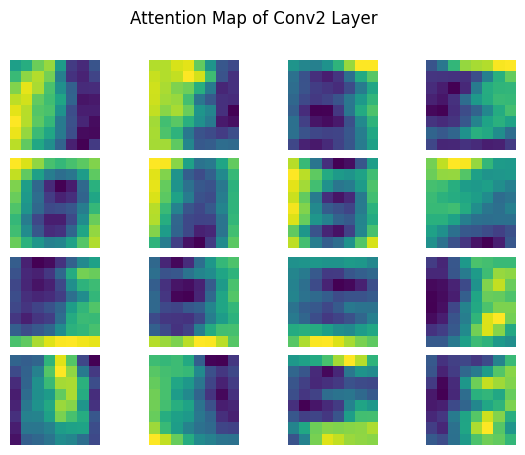

In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

round_num = 4
cid = 2
aggregate = True

clients = fl_exp.get_clients(round_num=round_num)
model = Net().to(DEVICE)
model.load_state_dict(clients[cid])

# Hook to capture the feature maps
activations = []

def hook_fn(module, input, output):
    activations.append(output)

# Register hooks to the convolutional layers
model.conv2.register_forward_hook(hook_fn)
# model.conv2.register_forward_hook(hook_fn)
_, _, test_loader_1 = fl_exp.client_loaders[cid]

loss, accuracy = test(model, test_loader_1, "cuda")

if(aggregate):
    activation_single = activations[0].mean(dim=0)
else:
    activation = activations[0].squeeze(0)  # Remove batch dimension
    activation_single = activation[0]  # Shape: [num_channels, height, width]

# Number of filters (channels) in the layer
num_filters = activation_single.shape[0]

# Plot the activation maps
fig, axs = plt.subplots(4, 4, figsize=(7, 5))
fig.suptitle("Attention Map of Conv2 Layer")
for i in range(num_filters):
    axs[i//4, i%4].imshow(activation_single[i].detach().cpu().numpy(), cmap='viridis')
    axs[i//4, i%4].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('plots/attention_c2.pdf')
plt.show()


In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

round_num = 4
cid = 2
aggregate = True

clients = fl_exp.get_clients(round_num=round_num)
model = Net().to(DEVICE)
model.load_state_dict(clients[cid])

_, _, test_loader_1 = fl_exp.client_loaders[cid]

# Get a batch of test data
data_iter = iter(test_loader_1)
images, labels = data_iter.next()
input_tensor = images.to(DEVICE)

# Define the target layers for GradCAM
target_layers = [model.conv2]

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(label.item()) for label in labels]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    
    # In this example grayscale_cam has the same number of images as the input batch:
    for i in range(len(grayscale_cam)):
        grayscale_cam_single = grayscale_cam[i, :]
        rgb_img = input_tensor[i].permute(1, 2, 0).cpu().numpy()
        visualization = show_cam_on_image(rgb_img, grayscale_cam_single, use_rgb=True)
        
        # Plot the activation maps
        plt.imshow(visualization)
        plt.axis('off')
        plt.title(f"Attention Map of Conv2 Layer for Image {i}")
        plt.savefig(f'plots/attention_grad_image_{i}.pdf')
        plt.show()

ModuleNotFoundError: No module named 'pytorch_grad_cam'